In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
import cv2
%matplotlib inline

/home/luowl/miniconda3/envs/main/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import codecs
import os
import os.path
import shutil
import string
import sys
import warnings
from typing import Any, Callable, Dict, List, Optional, Tuple
from urllib.error import URLError
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity
import hashlib

import numpy as np
import torch
from PIL import Image

def get_int(b: bytes) -> int:
    return int(codecs.encode(b, "hex"), 16)


SN3_PASCALVINCENT_TYPEMAP = {
    8: torch.uint8,
    9: torch.int8,
    11: torch.int16,
    12: torch.int32,
    13: torch.float32,
    14: torch.float64,
}


def read_sn3_pascalvincent_tensor(path: str, strict: bool = True) -> torch.Tensor:
    """Read a SN3 file in "Pascal Vincent" format (Lush file 'libidx/idx-io.lsh').
    Argument may be a filename, compressed filename, or file object.
    """
    # read
    with open(path, "rb") as f:
        data = f.read()
    # parse
    magic = get_int(data[0:4])
    nd = magic % 256
    ty = magic // 256
    assert 1 <= nd <= 3
    assert 8 <= ty <= 14
    torch_type = SN3_PASCALVINCENT_TYPEMAP[ty]
    s = [get_int(data[4 * (i + 1) : 4 * (i + 2)]) for i in range(nd)]

    num_bytes_per_value = torch.iinfo(torch_type).bits // 8
    # The MNIST format uses the big endian byte order. If the system uses little endian byte order by default,
    # we need to reverse the bytes before we can read them with torch.frombuffer().
    needs_byte_reversal = sys.byteorder == "little" and num_bytes_per_value > 1
    parsed = torch.frombuffer(bytearray(data), dtype=torch_type, offset=(4 * (nd + 1)))
    if needs_byte_reversal:
        parsed = parsed.flip(0)

    assert parsed.shape[0] == np.prod(s) or not strict
    return parsed.view(*s)

def read_label_file(path: str) -> torch.Tensor:
    x = read_sn3_pascalvincent_tensor(path, strict=False)
    assert x.dtype == torch.uint8
    assert x.ndimension() == 1
    return x.long()


def read_image_file(path: str) -> torch.Tensor:
    x = read_sn3_pascalvincent_tensor(path, strict=False)
    assert x.dtype == torch.uint8
    assert x.ndimension() == 3
    return x


class MNIST(VisionDataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
            and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
        train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
            otherwise from ``t10k-images-idx3-ubyte``.
        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    mirrors = [
        "http://yann.lecun.com/exdb/mnist/",
        "https://ossci-datasets.s3.amazonaws.com/mnist/",
    ]

    resources = [
        ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
        ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
        ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c"),
    ]

    training_file = "training.pt"
    test_file = "test.pt"
    classes = [
        "0 - zero",
        "1 - one",
        "2 - two",
        "3 - three",
        "4 - four",
        "5 - five",
        "6 - six",
        "7 - seven",
        "8 - eight",
        "9 - nine",
    ]

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set

        if self._check_legacy_exist():
            self.data, self.targets = self._load_legacy_data()
            return

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found. You can use download=True to download it")

        self.data, self.targets = self._load_data()

    def _check_legacy_exist(self):
        processed_folder_exists = os.path.exists(self.processed_folder)
        if not processed_folder_exists:
            return False

        return all(
            check_integrity(os.path.join(self.processed_folder, file)) for file in (self.training_file, self.test_file)
        )

    def _load_legacy_data(self):
        # This is for BC only. We no longer cache the data in a custom binary, but simply read from the raw data
        # directly.
        data_file = self.training_file if self.train else self.test_file
        return torch.load(os.path.join(self.processed_folder, data_file))

    def _load_data(self):
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        data = read_image_file(os.path.join(self.raw_folder, image_file))

        label_file = f"{'train' if self.train else 't10k'}-labels-idx1-ubyte"
        targets = read_label_file(os.path.join(self.raw_folder, label_file))

        return data, targets

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")
        img = np.array(img)
        img[img>0] = 1
        # img[img<=0.5] = 0
        img = img*255
        img = img.astype(np.uint8)
        # img = cv2.ximgproc.thinning(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        
        

        return img, target

    def __len__(self) -> int:
        return len(self.data)

    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "raw")

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "processed")

    @property
    def class_to_idx(self) -> Dict[str, int]:
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self) -> bool:
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
            for url, _ in self.resources
        )

    def download(self) -> None:
        """Download the MNIST data if it doesn't exist already."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)

        # download files
        for filename, md5 in self.resources:
            for mirror in self.mirrors:
                url = f"{mirror}{filename}"
                try:
                    print(f"Downloading {url}")
                    download_and_extract_archive(url, download_root=self.raw_folder, filename=filename, md5=md5)
                except URLError as error:
                    print(f"Failed to download (trying next):\n{error}")
                    continue
                finally:
                    print()
                break
            else:
                raise RuntimeError(f"Error downloading {filename}")

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])
data_train = MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

data_test = MNIST(root="./data/",
                           transform = transform,
                           train = False)

data_all = torch.utils.data.ConcatDataset([data_train, data_test])

In [8]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 64,
                                                shuffle = True,
                                                num_workers = 2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 64,
                                               shuffle = True,
                                                  num_workers = 2)
data_loader_all = torch.utils.data.DataLoader(dataset=data_all,
                                                batch_size = 64,
                                                shuffle = True,
                                                num_workers = 2)
                                                

torch.Size([1, 28, 28])


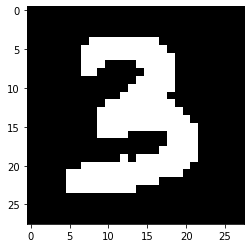

In [46]:
images, labels = next(iter(data_loader_train))
# img = torchvision.utils.make_grid(images)
img = images[0]
print(img.shape)
img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean

plt.imshow(img)
# print(img.sum())

In [49]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p=0.5),
                                         torch.nn.Linear(1024, 10))
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 14*14*128)
        x = self.dense(x)
        return x

In [50]:
# training
model = Model()
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [51]:
from tqdm import tqdm
for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, n_epochs))
    print("-"*10)
    for data in tqdm(data_loader_all):
        X_train, y_train = data
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        outputs = model(X_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0
    for data in data_loader_test:
        X_test, y_test = data
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(running_loss/len(data_train),
                                                                                      100*running_correct/len(data_train),
                                                                                      100*testing_correct/len(data_test)))

Epoch 0/5
----------


100%|██████████| 1094/1094 [00:08<00:00, 128.35it/s]


Loss is:0.0028, Train Accuracy is:111.4067%, Test Accuracy is:98.4700
Epoch 1/5
----------


100%|██████████| 1094/1094 [00:09<00:00, 110.63it/s]


Loss is:0.0010, Train Accuracy is:114.6667%, Test Accuracy is:98.9600
Epoch 2/5
----------


100%|██████████| 1094/1094 [00:10<00:00, 106.33it/s]


Loss is:0.0007, Train Accuracy is:115.2750%, Test Accuracy is:99.3100
Epoch 3/5
----------


100%|██████████| 1094/1094 [00:10<00:00, 102.26it/s]


Loss is:0.0005, Train Accuracy is:115.6967%, Test Accuracy is:99.5800
Epoch 4/5
----------


100%|██████████| 1094/1094 [00:10<00:00, 101.99it/s]


Loss is:0.0004, Train Accuracy is:115.8767%, Test Accuracy is:99.6200


In [52]:
torch.save(model.state_dict(), "mnist.pkl")